# Predicting Housing Prices Using Ensembles

**AIM:** To predict housing prices

**METHOD:** We will first prepare our data via various cleaning and transformation methods before using an ensemble of ML models.

**TARGET VARIABLE:** SalePrice

## Table of Contents
* [Importing Libraries and Familiarizing Ourselves With the Data](#step1)
* [Combining the Test and Training Datasets](#step2)
* [Cleaning the Data - Dealing with Null Values](#step3)
* [Feature Transformations](#step4)
* [Encoding & Scaling](#step5)
* [Transforming our Target](#step6)
* [Resplitting the Data into Training & Test sets](#step7)
* [Choosing our Model](#step8)
* [Training our Models](#step9)
* [Evaluating our Models Using Cross Validation](#step10)
* [Making Predictions](#step11)
* [Results](#step12)

### Step 1: Importing Libraries and Familiarizing Ourselves With the Data <a class="anchor" id="step1"></a>

In [6]:
! pip install pycaret[full] -q

In [7]:
#Importing libraries
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from pycaret.regression import setup, compare_models 


In [8]:
#Reading in the test and training data
housing_train_0 = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
housing_test_0 = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [9]:
#Taking a look at our training data information
print(housing_train_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
#Taking a look at our test data information
print(housing_test_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

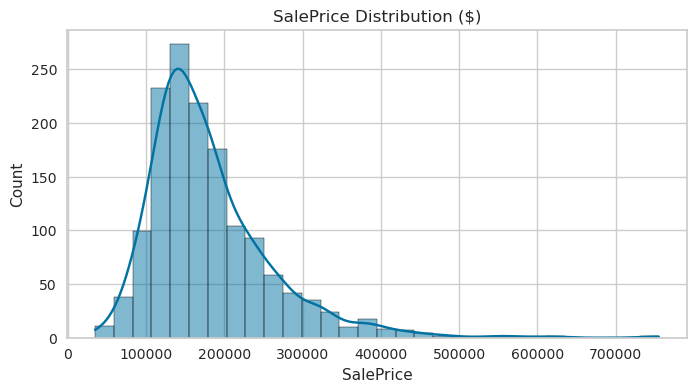

In [11]:
#Taking a look at the distribution of our target varible SalePrice
plt.figure(figsize=(8,4))
sns.histplot(housing_train_0['SalePrice'], color='b', bins=30, kde=True)
plt.title('SalePrice Distribution ($)')
plt.show()

Initial Observations:

- The SalePrice is right skewed. We can try to improve this with a transformation
- The MSSubClass seems to be incorrectly labeled as numeric when it should be an object

### Step 2: Combining the Test and Training Datasets <a class="anchor" id="step2"></a>
We want to avoid having columns in our test set that have been created as a result of anything we do to our training set; therefore before we move forward we will join the two datasets. After we perform any cleaning or transformations we'll split the dataset again.

In [12]:
housing_test_0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [13]:
housing_train_0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
#Combining training and test sets

#Only the training set contains the SalePrice column so we'll separate this from the join
target_var = housing_train_0['SalePrice']
target_var = target_var

#We'll also separate the Id column
id = housing_test_0['Id']

#Dropping the above columns from their respective datasets so they aren't included in the join
housing_train_1= housing_train_0.copy()
housing_train_1 = housing_train_1.drop(['SalePrice','Id'],axis=1)

housing_test_1 = housing_test_0.copy()
housing_test_1 = housing_test_1.drop('Id',axis=1)

#Joining both datasets
housing_full_0 = pd.concat([housing_train_1,housing_test_1],axis=0).reset_index(drop=True)

housing_full_0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [15]:
target_var.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePrice
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


Now that we've joined our datasets, we can begin cleaning

### Step 3: Cleaning the Data - Dealing with Null Values <a class="anchor" id="step3"></a>

In [16]:
#Replacing MSSubClass type with object
housing_full_0['MSSubClass'] = housing_full_0['MSSubClass'].astype('str')

In [17]:
#Extracting numerical features from the data
numerics = list(['int64','float64'])
num_data = housing_full_0.select_dtypes(numerics)

num_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [18]:
#Checking for null values
print(num_data.isnull().sum().sort_values(ascending=False))

LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
BsmtUnfSF          1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
BsmtFinSF2         1
BsmtFinSF1         1
TotRmsAbvGrd       0
3SsnPorch          0
EnclosedPorch      0
OpenPorchSF        0
WoodDeckSF         0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
Fireplaces         0
FullBath           0
KitchenAbvGr       0
BedroomAbvGr       0
HalfBath           0
LotArea            0
GrLivArea          0
LowQualFinSF       0
2ndFlrSF           0
1stFlrSF           0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
YrSold             0
dtype: int64


In [19]:
#Making a copy of our original df
housing_full_1 = housing_full_0.copy()

In [20]:
#Imputing the mean of each numeric column for the nulls
num_nulls = ['LotFrontage','GarageYrBlt','MasVnrArea','BsmtHalfBath','BsmtFullBath','BsmtUnfSF',
             'GarageCars','GarageArea','TotalBsmtSF','BsmtFinSF2','BsmtFinSF1']
for n in num_nulls:
    if housing_full_1[n].isna().sum() > 0:
        housing_full_1[n] = housing_full_1[n].fillna(np.mean(housing_full_1[n]))

#Check
print(housing_full_1[num_data.columns].isna().sum())


LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64


Moving on to our categorical columns for which we will use the mode of each column to fill in the null values. 

Before we do that, however, there are some columns where 'NA' doesn't correspond to a missing value, but instead the absence of that feature in the property. For these we will be replacing 'NA' with 'None'.
 

In [21]:
#Isolating our categorical data
cat_data = housing_full_1.select_dtypes('object')
cat_data.head()
print(cat_data.columns)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


In [22]:
#Checking how many categorical nulls exist in the data
cat_data.isna().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
GarageFinish      159
GarageCond        159
GarageQual        159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MSZoning            4
Functional          2
Utilities           2
KitchenQual         1
Exterior1st         1
Exterior2nd         1
Electrical          1
SaleType            1
PavedDrive          0
Heating             0
CentralAir          0
HeatingQC           0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
RoofMatl            0
RoofStyle           0
HouseStyle          0
BldgType            0
Condition2          0
Condition1          0
Neighborhood        0
LandSlope           0
LotConfig           0
LandContour         0
LotShape            0
Street              0
SaleCondition       0
dtype: int64

In [23]:
#Columns where NA should be replaced with None
nones = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

#Columns where NA should be replaced with the mode
nas = []
for c in cat_data.columns:
    if c not in nones:
        nas.append(c)


In [24]:
housing_full_2 = housing_full_1.copy()

In [25]:
#Replacing data with None or mode
for n in nones:
    housing_full_2[n] = housing_full_2[n].fillna('None')
for na in nas:
    housing_full_2[na] = housing_full_2[na].fillna((housing_full_2[na]).mode()[0])

In [26]:
#Checking how many categorical nulls now exist in the data
housing_full_2[cat_data.columns].isna().sum()


MSSubClass       0
MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

In [27]:
housing_full_2.isna().sum().sum()

0

Now that we have no more null values in our data, we can move on to Feature Transformation.

### Step 4: Feature Transformations <a class="anchor" id="step4"></a>
We are going to look at the distributions of each of the numerical columns. If they are not close to normal distribution, we'll transform them. This will help our chosen model perform better.

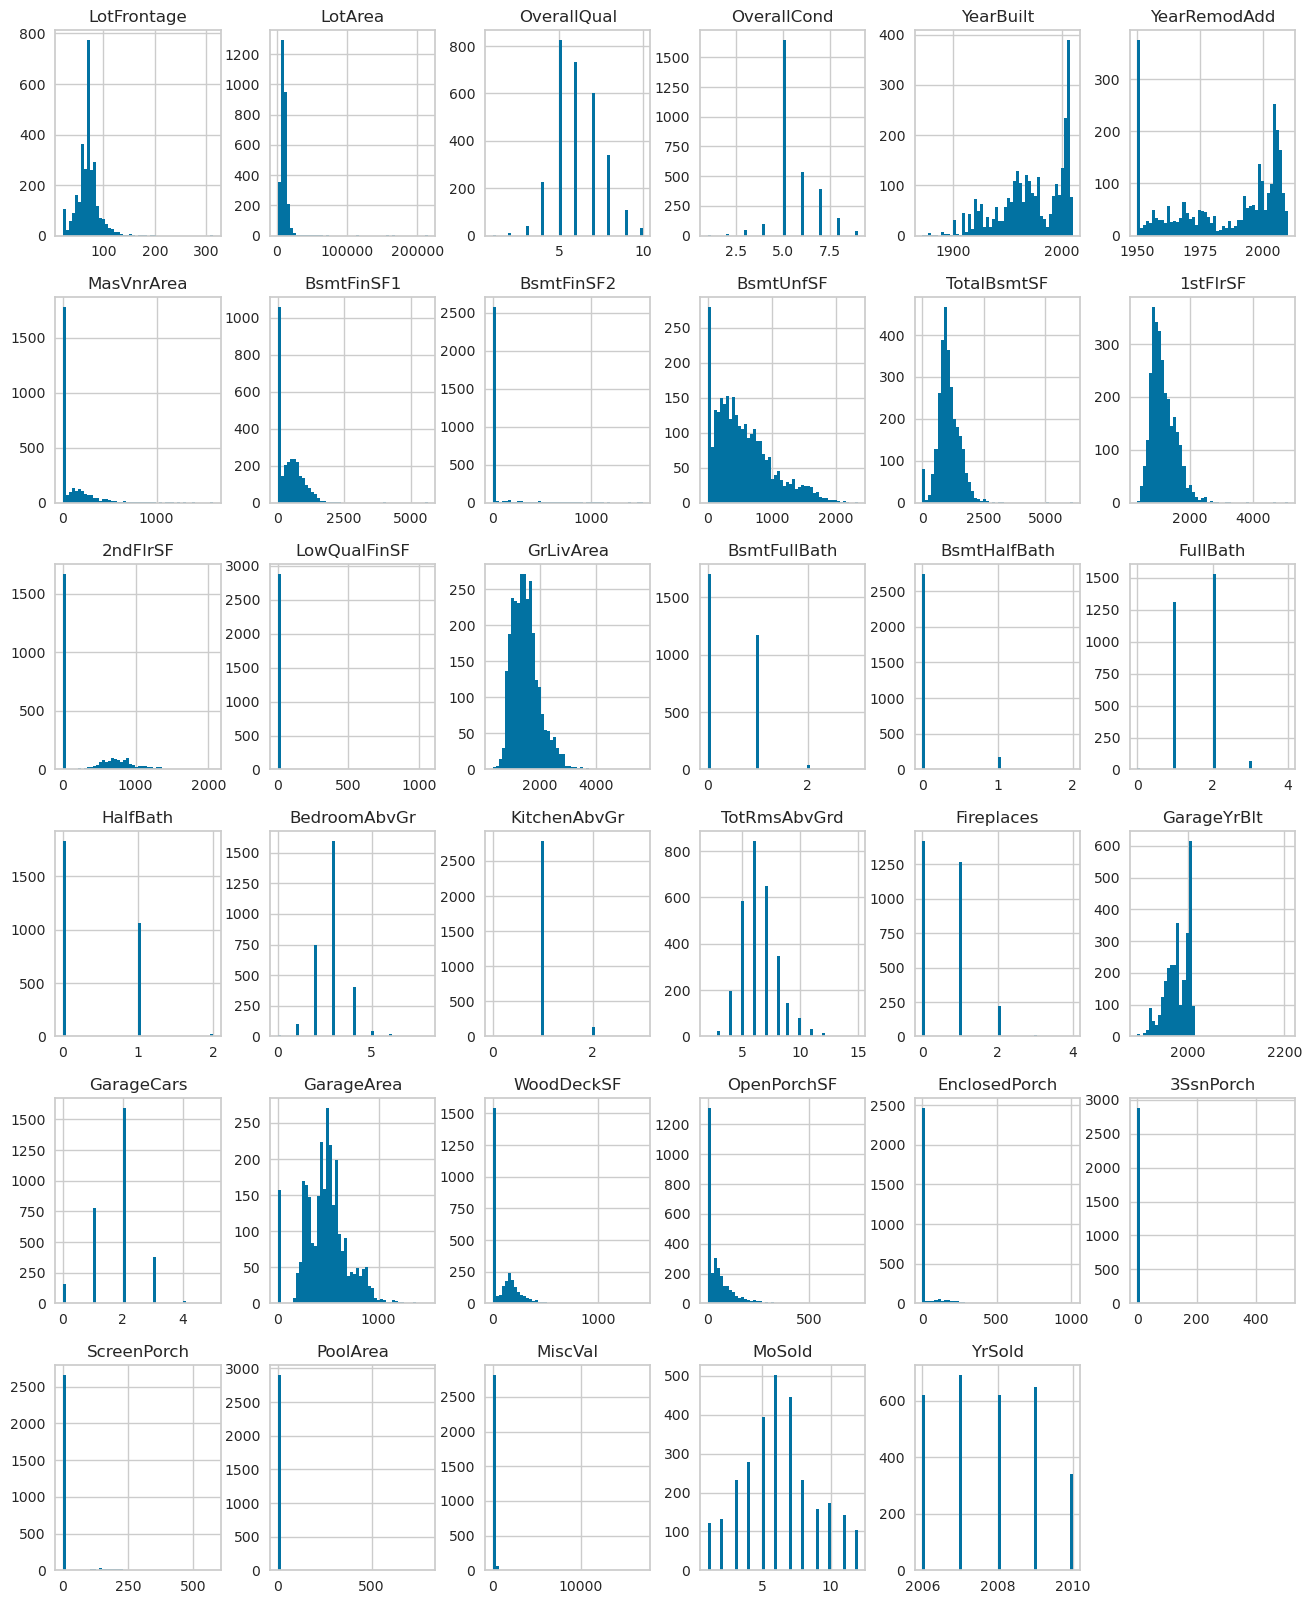

In [28]:
#Examining distributions in the numeric data
num_housing = housing_full_2.select_dtypes(numerics)
num_housing.hist(bins=50, figsize=(16, 20))
plt.show()

Quite a few demonstrate significant skewing. We'll transform these using logs.

In [29]:
#Log transformations of numeric columns with a skew of more than +0.6
skews = (abs(num_housing.skew()))
skews = skews[skews>0.6]
skews

LotFrontage       1.646420
LotArea          12.829025
YearBuilt         0.600114
MasVnrArea        2.612892
BsmtFinSF1        1.425966
BsmtFinSF2        4.148166
BsmtUnfSF         0.919981
TotalBsmtSF       1.163082
1stFlrSF          1.470360
2ndFlrSF          0.862118
LowQualFinSF     12.094977
GrLivArea         1.270010
BsmtFullBath      0.624276
BsmtHalfBath      3.933365
HalfBath          0.694924
KitchenAbvGr      4.304467
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
WoodDeckSF        1.843380
OpenPorchSF       2.536417
EnclosedPorch     4.005950
3SsnPorch        11.381914
ScreenPorch       3.948723
PoolArea         16.907017
MiscVal          21.958480
dtype: float64

In [30]:
housing_full_3 = housing_full_2.copy()

In [31]:
for i in housing_full_3.select_dtypes(numerics):
    if i in skews:
        housing_full_3[i] = np.log1p(housing_full_3[i])

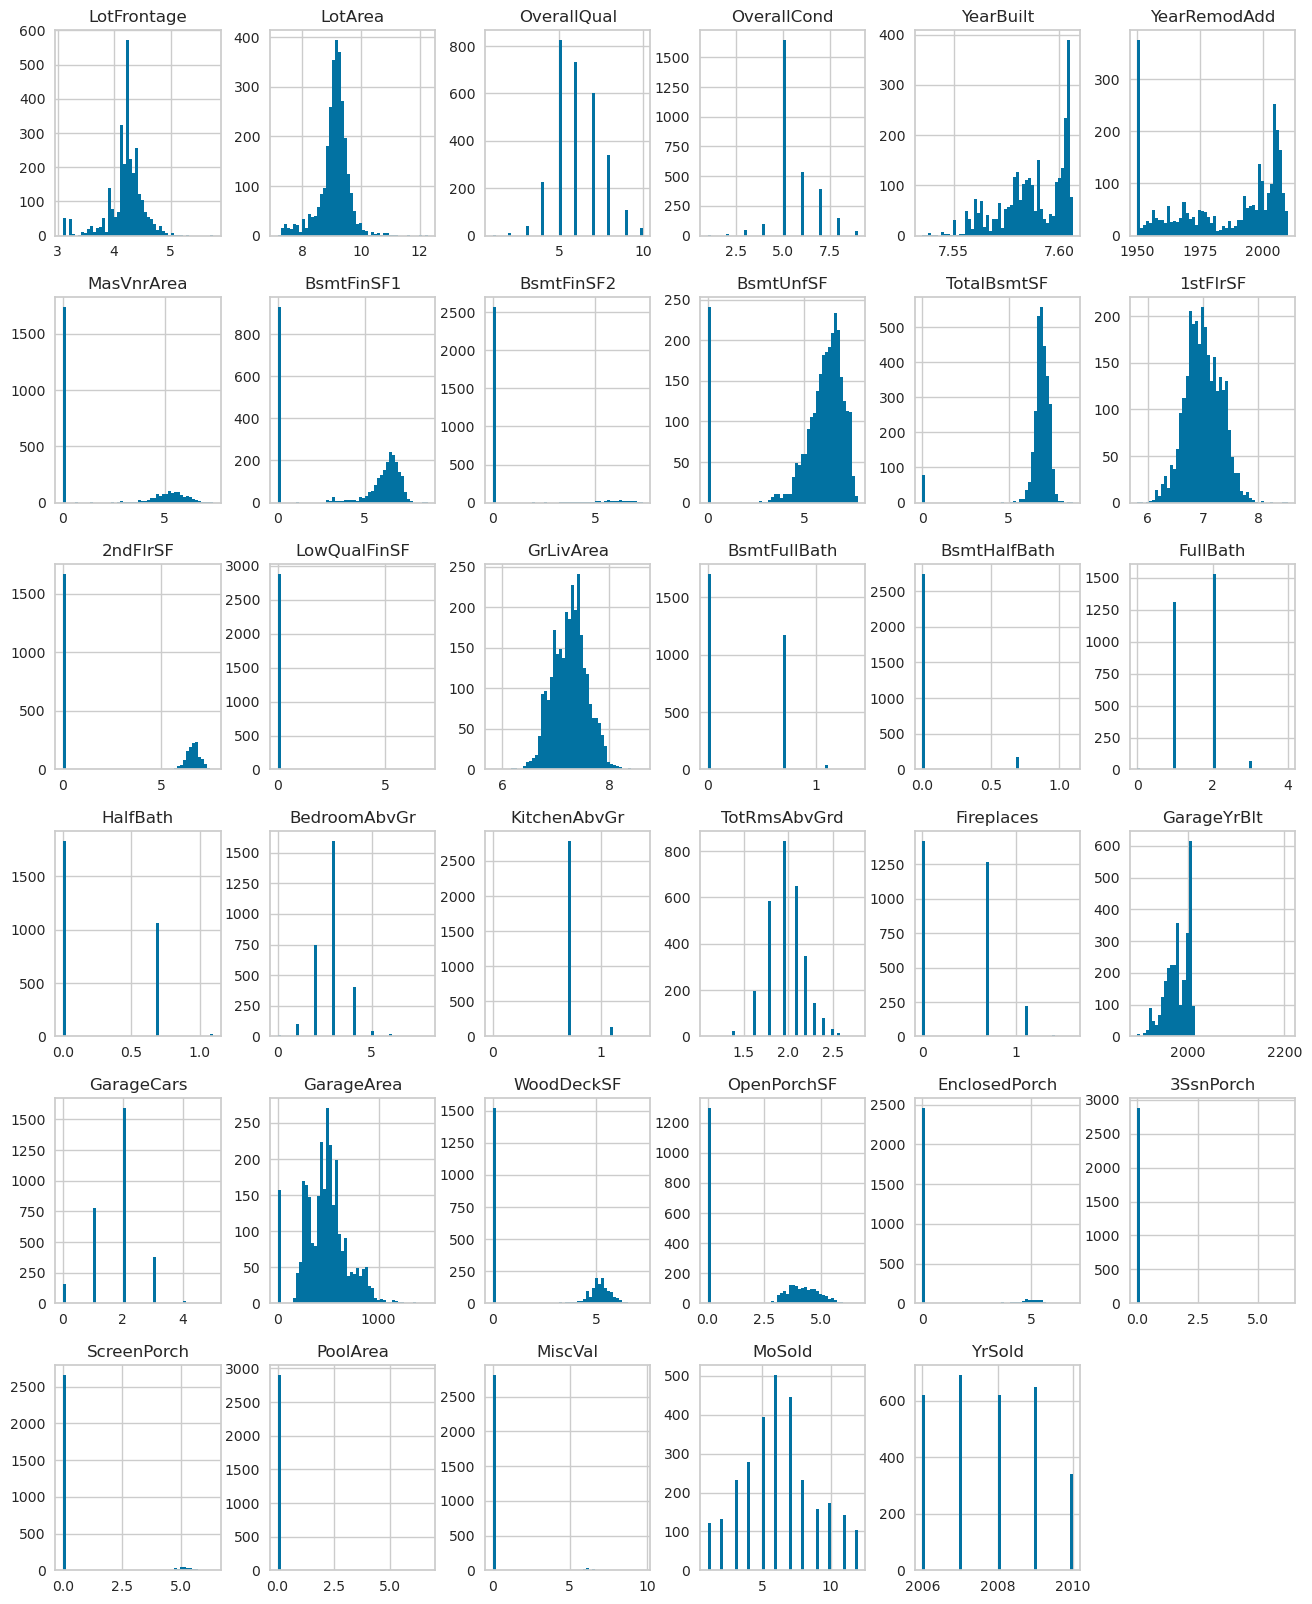

In [32]:
#Checking new distributions
housing_full_3.select_dtypes(numerics).hist(bins=50, figsize=(16, 20))
plt.show()

### Step 5: Encoding & Scaling <a class="anchor" id="step5"></a>
Next, we'll encode our categorical data using One-hot encoding and scale our numeric data.

In [33]:
housing_full_4 = housing_full_3.copy()

In [34]:
#Encoding our categorical columns
housing_full_4 = pd.get_dummies(housing_full_4)
housing_full_4.head()



,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,5,7.602900,2003,5.283204,6.561031,0.0,5.017280,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,6,8,7.589336,1976,0.000000,6.886532,0.0,5.652489,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,7,5,7.601902,2002,5.093750,6.188264,0.0,6.075346,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,7,5,7.557995,1970,0.000000,5.379897,0.0,6.293419,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,8,5,7.601402,2000,5.860786,6.486161,0.0,6.196444,...,0,0,0,1,0,0,0,0,1,0


In [35]:
housing_full_5 = housing_full_4.copy()

In [36]:
#Scaling the numeric columns
scaler = StandardScaler()
scaler.fit(housing_full_5)

#Scaler returns a np array so we'll transform this into a df
housing_full_5 = pd.DataFrame(scaler.transform(housing_full_5), columns=housing_full_5.columns, index=housing_full_5.index)
housing_full_5

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.049717,-0.103719,0.646183,-0.507284,1.040634,0.896833,1.207310,0.783085,-0.363104,-0.326929,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.588360,0.146544,-0.063185,2.188279,0.161526,-0.395604,-0.806456,0.892295,-0.363104,0.013451,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.088781,0.457629,0.646183,-0.507284,0.975922,0.848965,1.135097,0.658017,-0.363104,0.240041,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295173,0.136301,0.646183,-0.507284,-1.869638,-0.682812,-0.806456,0.386799,-0.363104,0.356896,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.738543,0.922662,1.355551,-0.507284,0.943542,0.753229,1.427464,0.757965,-0.363104,0.304932,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.472654,-2.993401,-1.481920,1.289758,-0.035461,-0.682812,-0.806456,-1.418231,-0.363104,0.362806,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.472654,-3.036401,-1.481920,-0.507284,-0.035461,-0.682812,-0.806456,0.438297,-0.363104,0.031931,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.728701,1.586172,-0.772552,1.289758,-0.365110,0.561757,-0.806456,0.967505,-0.363104,-3.015461,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.194659,0.311255,-0.772552,-0.507284,0.683917,0.370284,-0.806456,0.535481,-0.363104,0.390488,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


### Step 6 : Transforming our Target <a class="anchor" id="step6"></a>
As seen previously, our target variable is right skewed. We will perform a log transformation on this to help our models perform better.

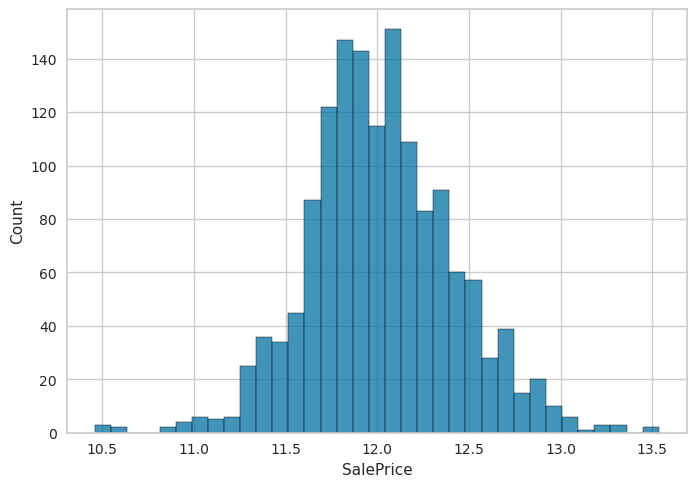

In [37]:
#Performing a log transformation on our target variable
transformed_target = np.log(target_var)

#Plotting the new distribution
sns.histplot(transformed_target)
plt.show()

### Step 7: Resplitting the Data into Training & Test sets <a class="anchor" id="step7"></a>

Now that we have cleaned and transformed our data, we'll need to split it back into the original test and training sets.

The training set contains 1460 rows and the test set contains 1459 rows. The data has not been shuffled in any way so we can just use these numbers to split the data.

In [38]:
#Creating our new training set
housing_train_2 = housing_full_5.loc[:1459,:]

#Checking the number of rows is correct
housing_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 317 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(317)
memory usage: 3.5 MB


In [39]:
#Creating our new training set
housing_test_2 = housing_full_5.loc[1460:,:].reset_index(drop=True)

#Checking the number of rows is correct
housing_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 317 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(317)
memory usage: 3.5 MB


### Step 8: Choosing our Model <a class="anchor" id="step8"></a>

We'll be using pycaret, a ML library, to choose the best model for our data.

In [40]:
#Initializing pycaret
pycaret_setup = setup(data=(pd.concat([housing_train_2,transformed_target],axis=1)), target='SalePrice')

,Description,Value
0,Session id,6902
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 318)"
4,Transformed data shape,"(1460, 318)"
5,Transformed train set shape,"(1021, 318)"
6,Transformed test set shape,"(439, 318)"
7,Numeric features,317
8,Preprocess,True
9,Imputation type,simple


In [41]:
#Now we'll use compare models to see the best performing models
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0794,0.0127,0.1119,0.9183,0.0087,0.0066,5.5550
omp,Orthogonal Matching Pursuit,0.0835,0.0137,0.1164,0.9120,0.0091,0.0070,0.0940
br,Bayesian Ridge,0.0846,0.0141,0.1181,0.9095,0.0092,0.0071,0.1070
gbr,Gradient Boosting Regressor,0.0866,0.0147,0.1211,0.9049,0.0094,0.0072,0.5300
lightgbm,Light Gradient Boosting Machine,0.0910,0.0164,0.1276,0.8944,0.0099,0.0076,0.9140
xgboost,Extreme Gradient Boosting,0.0921,0.0172,0.1305,0.8900,0.0101,0.0077,0.8950
ridge,Ridge Regression,0.0887,0.0174,0.1307,0.8882,0.0102,0.0074,0.0830
rf,Random Forest Regressor,0.0985,0.0192,0.1384,0.8763,0.0107,0.0082,1.1780
et,Extra Trees Regressor,0.1001,0.0202,0.1416,0.8703,0.0110,0.0084,1.1810
ada,AdaBoost Regressor,0.1261,0.0266,0.1627,0.8270,0.0126,0.0105,0.3710


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

From pycaret analysis the top 3 models for our data are:
- CatBoost Regressor
- Gradient Boosting Regressor
- Light Gradient Boosting Machine

To get the best results, we're going to use an ensemble of these to make our final predictions.

**Note:** Models performaces vary with each run of the code so the top three chosen may not match the top three in the compare_models table above.

### Step 9: Training our Models <a class="anchor" id="step9"></a>

In [42]:
#Creating a dictionary of our top models
top_models = {'catboost':CatBoostRegressor(verbose=0),
              'gbr': GradientBoostingRegressor(),
               'lightgbm' : LGBMRegressor() }

In [43]:
#Training our models on the training data
for model_name, model in top_models.items():
    model.fit(housing_train_2,transformed_target)

### Step 10: Evaluating our Models Using Cross Validation <a class="anchor" id="step10"></a>

In [44]:
from sklearn.model_selection import cross_validate

#Getting the cross validation score for each model using RMSE
cvs_results =  {}

for model_name, model in top_models.items():
    result = cross_validate(model, housing_train_2, transformed_target, scoring='neg_mean_squared_log_error', cv=10)
    cvs_results[model_name] = result
print(cvs_results)

{'catboost': {'fit_time': array([4.5852561 , 4.44241858, 4.47870493, 4.40649295, 4.46121025,
       4.52097702, 4.40456796, 4.61762667, 4.74800992, 4.51861858]), 'score_time': array([0.03325796, 0.02243257, 0.02399182, 0.02373195, 0.02343535,
       0.02264071, 0.02595019, 0.02662683, 0.02378106, 0.02247381]), 'test_score': array([-7.82144214e-05, -5.01982733e-05, -7.11270977e-05, -1.50873871e-04,
       -1.23608567e-04, -5.73652463e-05, -9.83702786e-05, -5.80188265e-05,
       -8.76904471e-05, -9.41647910e-05])}, 'gbr': {'fit_time': array([1.16468191, 1.18352604, 1.17600036, 1.16002417, 1.1495502 ,
       1.15205169, 1.15887761, 1.16045165, 1.15229964, 1.15666938]), 'score_time': array([0.00714254, 0.00685692, 0.00702143, 0.0070169 , 0.00687265,
       0.00704026, 0.00687313, 0.00678468, 0.00681019, 0.00690079]), 'test_score': array([-1.04882433e-04, -6.34940496e-05, -7.63083584e-05, -1.35960468e-04,
       -1.38952219e-04, -6.64711568e-05, -1.16261377e-04, -7.21967251e-05,
       -7.

In [45]:
#Taking the mean of each round of scores

print('catboost mean RMSE score:' , np.mean(cvs_results['catboost']['test_score']))
print('gbr mean RMSE score:' , np.mean(cvs_results['gbr']['test_score']))
print('lightgbm mean RMSE score:' , np.mean(cvs_results['lightgbm']['test_score']))


catboost mean RMSE score: -8.696318200478574e-05
gbr mean RMSE score: -9.599032455846988e-05
lightgbm mean RMSE score: -0.00010171651162108057


These errors are in relation to the Log tranfromation of the target column. To gain a better understanding of how they relate to our original target, we'll perform some calculations.

In [46]:
#Adjusting each mean RSME score to reflect the original data -  taking exponents and sqrts
print('catboost mean MSE Score:' , np.exp(np.sqrt(np.mean(-cvs_results['catboost']['test_score']))))
print('gbr mean MSE score:' , np.exp(np.sqrt(np.mean(-cvs_results['gbr']['test_score']))))
print('lightgbm mean MSE score:' , np.exp(np.sqrt(np.mean(-cvs_results['lightgbm']['test_score']))))

catboost mean MSE Score: 1.0093690222603764
gbr mean MSE score: 1.009845617501483
lightgbm mean MSE score: 1.0101364900710796


These scores look pretty promising. Let's make some predictions.

### Step 11: Making Predictions <a class="anchor" id="step11"></a>

In [47]:
#Combining our models to make a set of predictions
predictions = (np.exp(top_models['catboost'].predict(housing_test_2))*0.33+
np.exp(top_models['gbr'].predict(housing_test_2))*0.33+
np.exp(top_models['lightgbm'].predict(housing_test_2))*0.33)

In [48]:
#Making our predictions a series so we can add it to a DF
predictions =  pd.Series(predictions)
predictions

#Combining our predictions with the Ids we extracted at the beginning
final_predictions = pd.concat([id,predictions], axis=1)
final_predictions.columns = ['Id','SalePrice']

In [49]:
#Looking at our final predictions
final_predictions

,Id,SalePrice
0,1461,121918.192102
1,1462,156647.672572
2,1463,182050.411938
3,1464,188762.405810
4,1465,186749.561811
...,...,...
1454,2915,79003.457139
1455,2916,80555.527945
1456,2917,158854.834341
1457,2918,114410.671401


### Step 12: Preparing for Kaggle Submission <a class="anchor" id="step12"></a>

In [50]:
submission = final_predictions

submission.to_csv('./submission.csv', index =False, header=True)

# Kaggle Results

## Rank: 850/4402
## Percentile: 19.3%

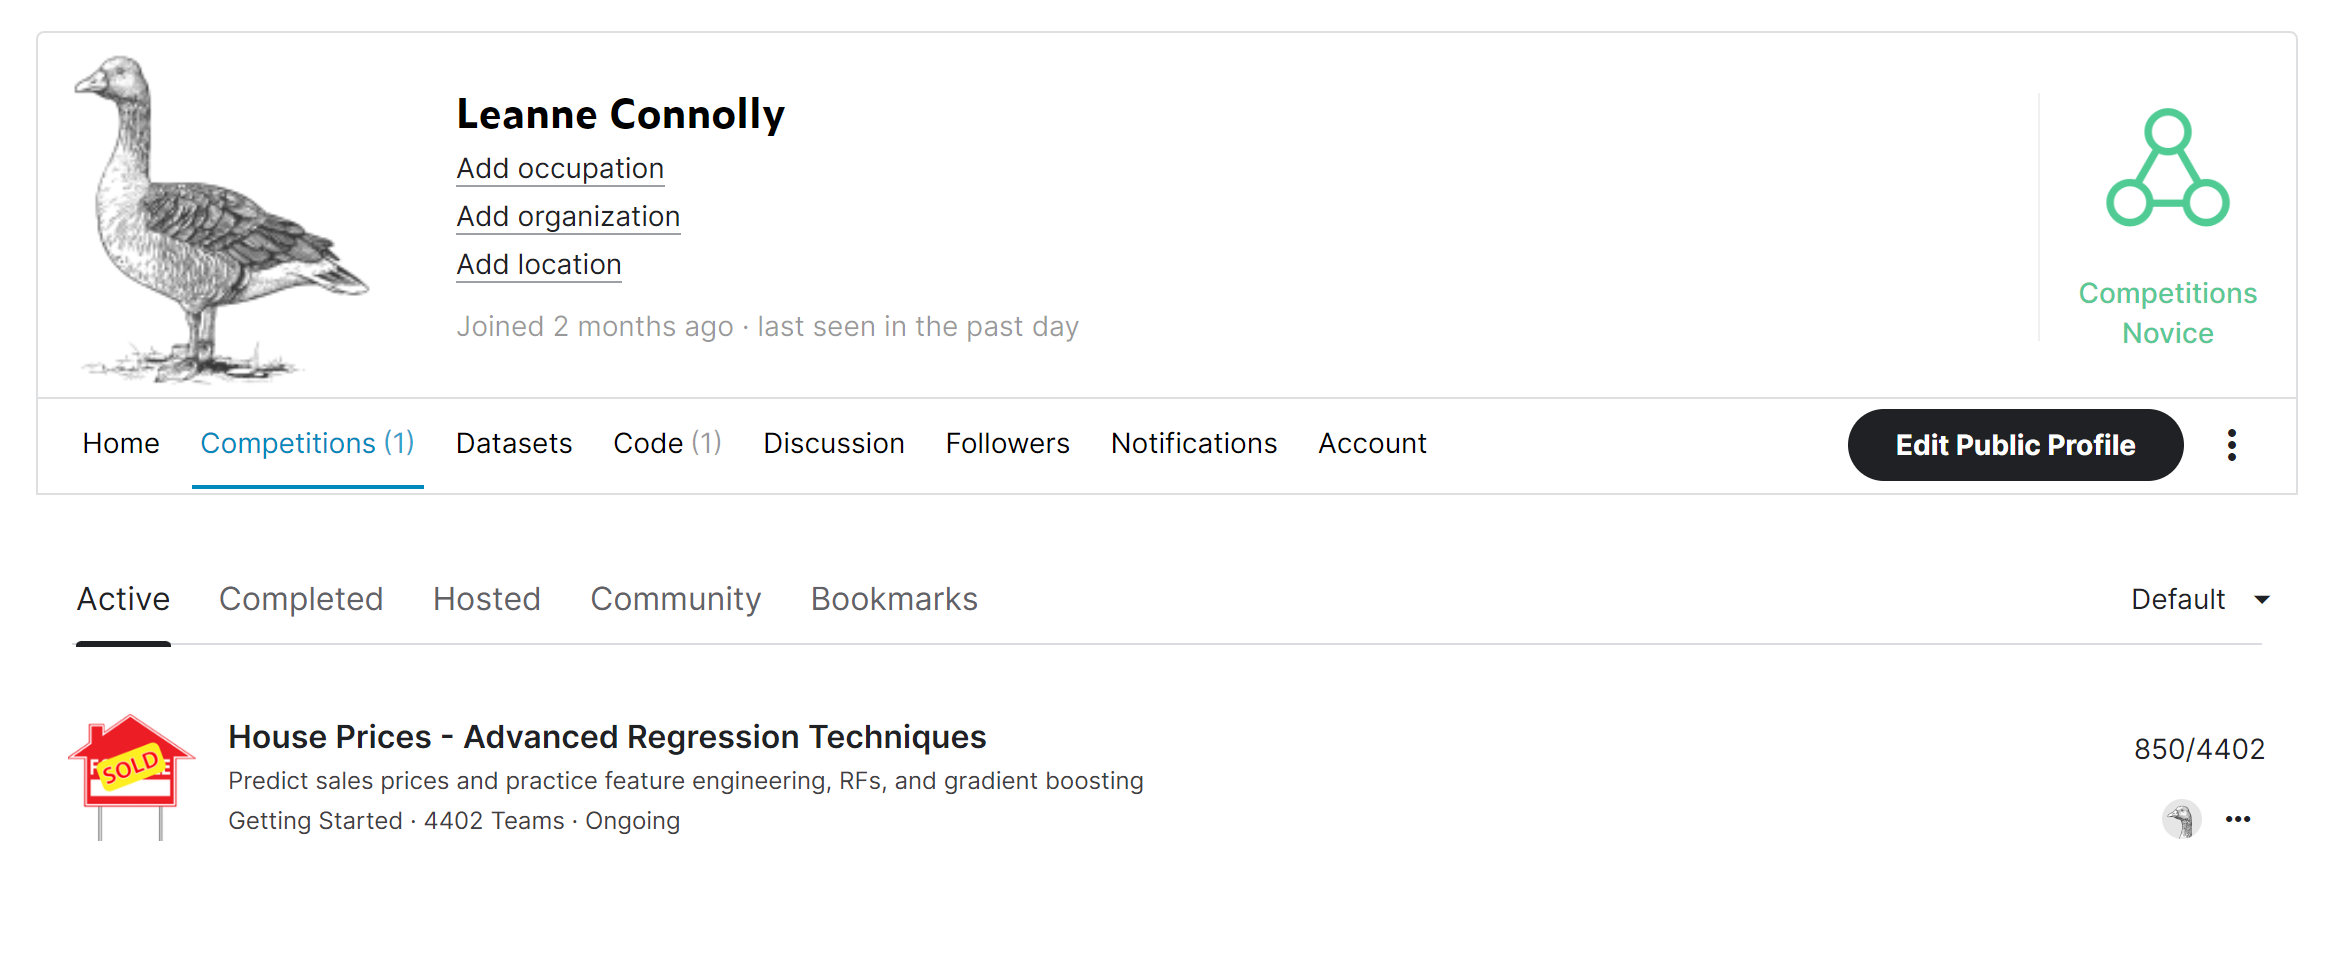